オリジナルの作成: 2016/05/15

<html>
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>SageでTheanoのDenosingオートエンコーダを試す</h1>
	<h2>参考サイト</h2>
	<p>	
		ここでは、
		 <a href="http://aidiary.hatenablog.com/">人工知能に関する断創録</a>
		 のTheanoに関連する記事をSageのノートブックで実装し、Thenoの修得を試みます。	
	</p>
	<p>
		今回は、TheanoのTutorialからDenoisingオートエンコーダの例を以下のページを参考にSageのノートブックで試してみます。
		<ul>
			<li>
				<a href="http://sinhrks.hatenablog.com/entry/2014/12/15/081113">Theano で Deep Learning <4> : Denoising オートエンコーダ</a>
			</li>
			<li>
				<a href="http://aidiary.hatenablog.com/entry/20151203/1449146680">Theanoによる自己符号化器の実装</a>
			</li>
		</ul>		
	</p>
</html>

<html>
	<h2>前準備</h2>
	<h3>処理系をSageからPythonに変更</h3>
	<p>
		SageでTheanoのtutorialのCNNを実行すると、TypeError: 'sage.rings.integer.Integer' object is not iterable
		のエラーになるため、今回もPythonを使用します。	
	</p>
	<p>
		そこで、ノートブックの処理系をSageからPythonに切り替えます。上部の左から4つめのプルダウンメニューから
		「python」を選択してください。
	</p>
	<p>
		<img src="images/theano_setup.png"/>
	</p>
</html>

<html>
	<h3>必要なライブラリのimport</h3>
	<p>
		最初に、theanoを使うのに必要なライブラリをインポートします。
	</p>
</html>

In [1]:
# 必要なライブラリのインポート
import six.moves.cPickle as pickle
import gzip
import timeit
import time

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams

# これまで確認したlogistic_sgd.pyのLogisticRegressionをインポートする
from logistic_sgd import LogisticRegression, load_data

# 重みの可視化用
from PIL import Image
from utils import tile_raster_images

<html>
	<h2>オートエンコーダ (Autoencoder)</h2>
	<p>
		オートエンコーダ（Autoencoder）は、日本語では自己符号化器と呼ばれています。
	</p>
	<p>
		ニューラルネットワークの計算では、重みの初期値が収束に大きく影響を及ぼすことが知られています。
		オートエンコーダでは特徴を抽出しやすいような重みの初期値を、入力・隠れ層・出力から成る3層の
		ニューらネットワークを使って入力と同じ出力を生成することで求めます。
	</p>
	<p>
		DeepLearning 0.1 Documentationの式では、真ん中の隠れ層の値yは、以下の様になります。
$$
	y = s(W x + b)
$$		
		そして、出力層の値zをyを使って表すと、
$$
	z = s(W' y + b')
$$		
		のようになります。xをyに変換するプロセスを符号化（encode）、yをzに変換するプロセスを復号化（decode）と呼びます。
		これらを一つにまとめると以下の様になります。
$$
	z = s( W'( s(W x + b) ) + b')
$$		
	</p>
	<p>
		<a href="http://sinhrks.hatenablog.com/entry/2014/12/15/081113">Theano で Deep Learning <4> : Denoising オートエンコーダ</a>
		からオートエンコーダの構成図を引用します。
	</p>
	<p>
		<img width="50%" height="50%" src="http://cdn-ak.f.st-hatena.com/images/fotolife/s/sinhrks/20141214/20141214232002.png"
	</p>
	<p>
		<ul>
			<li>W: 入力層・隠れ層間の重み行列、次元は（入力データの次元、隠れ層の次元）</li>
			<li>b: 入力層・隠れ層間のバイアスベクトル、次元は（隠れ層の次元）</li>
			<li>s: 活性化関数</li>
			<li>W': 隠れ層・出力層間の重み行列、次元は（隠れ層の次元、入力データの次元）、$W' = W^T$の重み共有（tied weight）の制約を入れています</li>
			<li>b': 隠れ層・出力層間のバイアスベクトル、次元は（入力データの次元）</li>
		</ul>
	</p>
</html>

<html>
	<h3>オートエンコーダの損失関数</h3>
	<p>
		<a href="http://aidiary.hatenablog.com/entry/20151203/1449146680">Theanoによる自己符号化器の実装</a>
		のコメントに、入力xが[0,1]で正規化されていることを前提にしてとあるこの部分が大切です。
		オートエンコーダの損失関数は、交差エントロピー誤差関数が使えます。
$$
	L_H(x, z) = - \sum_{k=1}^d \left (x_k log z_k + (1 - x_k) log( 1 - z_k) \right )
$$		
	</p>
</html>

<html>
	<h2>オートエンコーダの実装</h2>
	<p>
		オートエンコーダとDenoisingオートエンコーダでコードを再利用できるように、
		オートエンコーダに入力をそのまま返すget_corrupted_inputメソッドを追加しました。
		<pre>
    def get_corrupted_input(self, input, corruption_level):
        return input			
		</pre>
	</p>
	<p>
		損失関数の値L(結果はミニバッチサイズのベクトル)は、get_hidden_valuesメソッドは隠れ層の出力yを計算し、get_reconstructed_inputメソッドは、
		出力層の出力zを使って以下の様に計算します。
		<pre>
        tilde_x = self.get_corrupted_input(self.x, corruption_level)      
        y = self.get_hidden_values(tilde_x)
        z = self.get_reconstructed_input(y)
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)
		</pre>		
	</p>
	<p>
		<a href="http://aidiary.hatenablog.com/entry/20151203/1449146680">Theanoによる自己符号化器の実装</a>
		の、損失関数計算の模式図がとても分かりやすいので、引用させて頂きます。
	</p>
	<p>
		<img width="50%" height="50%" src="http://cdn-ak.f.st-hatena.com/images/fotolife/a/aidiary/20151203/20151203101935.png"/>
	</p>
</html>

In [2]:
class Autoencoder(object):
    def __init__(self, numpy_rng, theano_rng=None,
                 input=None,
                 n_visible=784, n_hidden=500,
                 W=None, bhid=None, bvis=None):
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        if not W:
            # 入力層と出力層の間の重み
            initial_W = np.asarray(
                numpy_rng.uniform(
                    low=-4 * np.sqrt(6.0 / (n_hidden + n_visible)),
                    high=4 * np.sqrt(6.0 / (n_hidden + n_visible)),
                    size=(n_visible, n_hidden)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=initial_W, name='W', borrow=True)

        if not bvis:
            # 入力層（visible）のユニットのバイアス
            bvis = theano.shared(
                value=np.zeros(n_visible, dtype=theano.config.floatX),
                borrow=True)

        if not bhid:
            # 隠れ層（hidden）のユニットのバイアス
            bhid = theano.shared(
                value=np.zeros(n_hidden, dtype=theano.config.floatX),
                name='b',
                borrow=True)

        # パラメータ
        self.W = W
        self.b = bhid
        self.W_prime = self.W.T
        self.b_prime = bvis
        self.params = [self.W, self.b, self.b_prime]

        self.theano_rng = theano_rng

        if input is None:
            self.x = T.dmatrix(name='input')
        else:
            self.x = input

    # Denoisingに合わせたメソッドで入力をそのまま返す
    def get_corrupted_input(self, input, corruption_level):
        return input
        
    def get_hidden_values(self, input):
        """入力層の値を隠れ層の値に変換"""
        return T.nnet.sigmoid(T.dot(input, self.W) + self.b)

    def get_reconstructed_input(self, hidden):
        """隠れ層の値を入力層の値に逆変換"""
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b_prime)

    def get_cost_updates(self, corruption_level, learning_rate):
        """コスト関数と更新式のシンボルを返す"""
        # Denoisingされたxを求める
        tilde_x = self.get_corrupted_input(self.x, corruption_level)
        # 入力を変換
        y = self.get_hidden_values(tilde_x)

        # 変換した値を逆変換で入力に戻す
        z = self.get_reconstructed_input(y)

        # コスト関数のシンボル
        # 元の入力と再構築した入力の交差エントロピー誤差を計算
        # 入力xがミニバッチのときLはベクトルになる
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)

        # Lはミニバッチの各サンプルの交差エントロピー誤差なので全サンプルで平均を取る
        cost = T.mean(L)

        # 誤差関数の微分
        gparams = T.grad(cost, self.params)

        # 更新式のシンボル
        updates = [(param, param - learning_rate * gparam)
                   for param, gparam in zip(self.params, gparams)]

        return cost, updates

    def feedforward(self):
        """入力をフィードフォワードさせて出力を計算"""
        y = self.get_hidden_values(self.x)
        z = self.get_reconstructed_input(y)
        return z

    def __getstate__(self):
        """パラメータの状態を返す"""
        return (self.W.get_value(), self.b.get_value(), self.b_prime.get_value())

    def __setstate__(self, state):
        """パラメータの状態をセット"""
        self.W.set_value(state[0])
        self.b.set_value(state[1])
        self.b_prime.set_value(state[2])

<html>
	<h3>ミニMNISTのデータでオートエンコーダを試す</h3>
	<p>
		MNISTのデータの1/10のサブセットミニMNISTのデータを使って、オートエンコーダを試してみましょう。
		training_epochsは、サイズを1/10にしたので、10倍の200としました。
	</p>
	<p>
		さくらの1GメモリのVPSで、約15分掛かりました。
	</p>
</html>

In [3]:
# MNISTの1/10のサブセットなので、学習回数のtraining_epochsを10倍の200で実行
learning_rate = 0.1
training_epochs = 200
batch_size = 20

# 学習データのロード
datasets = load_data('data/mini_mnist.pkl.gz')
# 自己符号化器は教師なし学習なので訓練データのラベルは使わない
train_set_x = datasets[0][0]

# ミニバッチ数
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size

# ミニバッチのインデックスを表すシンボル
index = T.lscalar()

# ミニバッチの学習データを表すシンボル
x = T.matrix('x')

# モデル構築
rng = np.random.RandomState(123)
theano_rng = RandomStreams(rng.randint(2 ** 30))

autoencoder = Autoencoder(numpy_rng=rng,
                           theano_rng=theano_rng,
                           input=x,
                           n_visible=28 * 28,
                           n_hidden=100)

# コスト関数と更新式のシンボルを取得
cost, updates = autoencoder.get_cost_updates(corruption_level=0., learning_rate=learning_rate)

# 訓練用の関数を定義
train_da = theano.function([index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size]
    })

# モデル訓練
start_time = time.clock()
for epoch in xrange(training_epochs):
    c = []
    for batch_index in xrange(n_train_batches):
        c.append(train_da(batch_index))
    if epoch%10 == 0:
        print "Training epoch %d, cost %f" % (epoch, np.mean(c))

end_time = time.clock()
training_time = (end_time - start_time)

print "time: %ds" % (training_time)

... loading data
Training epoch 0, cost 132.518026
Training epoch 10, cost 80.232354
Training epoch 20, cost 75.058689
Training epoch 30, cost 73.097621
Training epoch 40, cost 72.148517
Training epoch 50, cost 71.565361
Training epoch 60, cost 71.142682
Training epoch 70, cost 70.810096
Training epoch 80, cost 70.536880
Training epoch 90, cost 70.316258
Training epoch 100, cost 70.139160
Training epoch 110, cost 69.992795
Training epoch 120, cost 69.867721
Training epoch 130, cost 69.757125
Training epoch 140, cost 69.657424
Training epoch 150, cost 69.567555
Training epoch 160, cost 69.485009
Training epoch 170, cost 69.409063
Training epoch 180, cost 69.339174
Training epoch 190, cost 69.275876
time: 182s


<html>
	<p>
		重みの可視化は、Deep Learning Tutorialのソースutils.pyに含まれているtile_raster_images関数を使用しました。
	</p>
	<p>
		結果は、ちょっと気持ち悪い形をしていますが、黒色のくぼみの部分に注目してみてください。
	</p>
</html>

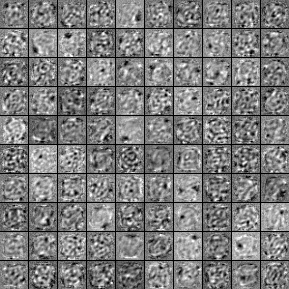

In [4]:
# 重みの可視化（utils.pyのtile_raster_imagesを利用）
Image.fromarray(tile_raster_images(
    X=autoencoder.W.get_value(borrow=True).T,
    img_shape=(28, 28), tile_shape=(10, 10),
    tile_spacing=(1, 1)))

<html>
	<p>
		テストデータを使ってオートエンコーダで復元された画像をオリジナルと比べてみましょう。そこそこ復元できているのが分かります。
	</p>	
</html>

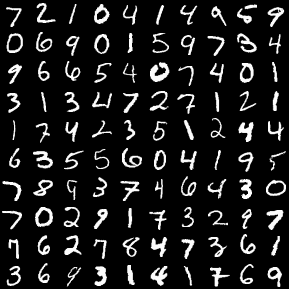

In [5]:
# テスト用データで確認
test_set_x = datasets[2][0]
y = autoencoder.get_hidden_values(test_set_x[:100])
z = autoencoder.get_reconstructed_input(y).eval()

# テスト画像
Image.fromarray(tile_raster_images(
    X=test_set_x.eval(),
    img_shape=(28, 28), tile_shape=(10, 10),
    tile_spacing=(1, 1)))

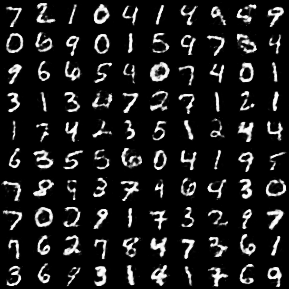

In [6]:
# Autoencoderで復元された画像
Image.fromarray(tile_raster_images(
    X=z,
    img_shape=(28, 28), tile_shape=(10, 10),
    tile_spacing=(1, 1)))

<html>
	<h2>Denoisingオートエンコーダ</h2>
	<p>
		Denosingとは聞き慣れない言葉ですが、ノイズを画像に加えることを言います。
	</p>
	<p>
		与えるノイズは二項分布の乱数で生成します。以下に10 x 10の空間に、ノイズ30%（corruption_level=0.3）で
		生成されたノイズの分布を示します。30%と言ってもかなりノイズが埋まってしまうものだと感じました。
	</p>
	<p>
		この様子を	説明した
		<a href="http://sinhrks.hatenablog.com/entry/2014/12/15/081113">Theano で Deep Learning <4> : Denoising オートエンコーダ</a>
		のアニメキャラクタの図を引用します。
	</p>
	<p>
		<img width="50%" height="50%" src="http://cdn-ak.f.st-hatena.com/images/fotolife/s/sinhrks/20141214/20141214201324.png"
	</p>
</html>

In [7]:
corruption_level = 0.3

rng = np.random.RandomState(123)
theano_rng = RandomStreams(rng.randint(2 ** 30))
binomial = theano_rng.binomial(size=(10, 10), n=1, p=1 - corruption_level, dtype=theano.config.floatX)
binomial.eval()

array([[ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.],
       [ 1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.],
       [ 1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.]])

<html>
	<h3>Denoisingオートエンコーダ</h3>
	<p>
		Denoisingオートエンコーダの実装は、とても簡単です。
		get_corrupted_inputメソッドで入力データに二項分布のノイズを掛け合わせた結果を返すだけです。
	</p>
</html>

In [8]:
class DenoisingAutoencoder(Autoencoder):
    def __init__(self, numpy_rng, theano_rng=None,
                 input=None,
                 n_visible=784, n_hidden=500,
                 W=None, bhid=None, bvis=None):
        Autoencoder.__init__(self,  numpy_rng, theano_rng, input, n_visible, n_hidden, W, bhid, bvis)
    
    def get_corrupted_input(self, input, corruption_level):
        return self.theano_rng.binomial(size=input.shape, n=1,
                                        p=1 - corruption_level,
                                        dtype=theano.config.floatX) * input

<html>
	<h3>ミニMNISTのデータでDenosingオートエンコーダを試す</h3>
	<p>
		早速、ミニMNISTのデータでDenosingの効果をみてみましょう。
	</p>
	<p>
		ミニバッチの条件はオートエンコーダと同じなので、まずDenosingAutoencoderを生成し、dAにセットします。
	</p>
	<p>
		つぎに、コスト関数と更新式を取得し、訓練用の関数を定義します。
	</p>
	<p>
		計算はさくらのVPSで約17分で、コスト関数の値はオートエンコーダのときより若干高いです。
	</p>
</html>

In [9]:
# 以下の項目は、Autoencoderで設定しているので省略
## 学習データのロード
## ミニバッチ数
## ミニバッチのインデックスを表すシンボル
## ミニバッチの学習データを表すシンボル

# モデル構築
dA = DenoisingAutoencoder(numpy_rng=rng,
                           theano_rng=theano_rng,
                           input=x,
                           n_visible=28 * 28,
                           n_hidden=100)

# コスト関数と更新式のシンボルを取得
cost, updates = dA.get_cost_updates(corruption_level=0.3, learning_rate=learning_rate)

# 訓練用の関数を定義
train_da = theano.function([index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size]
    })

# モデル訓練
start_time = time.clock()
for epoch in xrange(training_epochs):
    c = []
    for batch_index in xrange(n_train_batches):
        c.append(train_da(batch_index))
    if epoch%10 == 0:
        print "Training epoch %d, cost %f" % (epoch, np.mean(c))

end_time = time.clock()
training_time = (end_time - start_time)

print "time: %ds" % (training_time)

Training epoch 0, cost 138.405057
Training epoch 10, cost 87.162786
Training epoch 20, cost 83.476929
Training epoch 30, cost 81.844325
Training epoch 40, cost 80.727820
Training epoch 50, cost 79.953129
Training epoch 60, cost 79.360116
Training epoch 70, cost 78.839937
Training epoch 80, cost 78.408522
Training epoch 90, cost 77.952378
Training epoch 100, cost 77.572687
Training epoch 110, cost 77.342092
Training epoch 120, cost 77.164052
Training epoch 130, cost 76.968730
Training epoch 140, cost 76.653768
Training epoch 150, cost 76.618222
Training epoch 160, cost 76.326465
Training epoch 170, cost 76.133495
Training epoch 180, cost 76.044698
Training epoch 190, cost 75.996942
time: 216s


<html>
	<h3>結果の可視化</h3>
	<p>
		オートエンコーダの場合と同様に重み行列を可視化して比べてみましょう。
	</p>
	<p>
		Denosingオートエンコーダの方が、形がシャープになっていることが分かります。
	</p>
	<p>
		あの気持ち悪い画像もいくつか残っています。もしかすると気持ちが悪い画像はランダムなもので、
		隠れ層のサイズを100としましたが、まだ小さくても数値画像の特徴を表現するには十分であることを
		意味してるのではないかと感じました。
	</p>
</html>

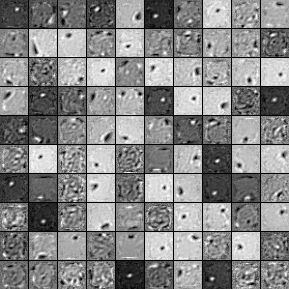

In [10]:
# 重みの可視化（utils.pyのtile_raster_imagesを利用）
Image.fromarray(tile_raster_images(
    X=dA.W.get_value(borrow=True).T,
    img_shape=(28, 28), tile_shape=(10, 10),
    tile_spacing=(1, 1)))

<html>
	<h3>復元されたデータの比較</h3>
	<p>
		オートエンコーダとDenoisingオートエンコーダで復元された数字画像を比較してみます。
	</p>
	<p>
		オートエンコーダよりもDenoisingオートエンコーダの数字の方がはっきりしているように思います。
	</p>
</html>

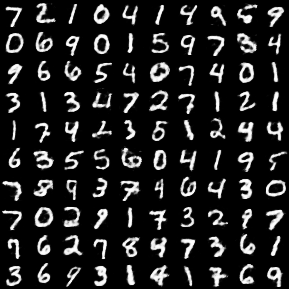

In [11]:
# DenoisingAutoencoderで復元された画像
y = dA.get_hidden_values(test_set_x[:100])
z = dA.get_reconstructed_input(y).eval()

Image.fromarray(tile_raster_images(
    X=z,
    img_shape=(28, 28), tile_shape=(10, 10),
    tile_spacing=(1, 1)))